# Load text data

In [1]:
import pandas as pd

# load the dataset
df = pd.read_csv('./Movie.csv', skipinitialspace=True) # encoding='latin'

# random state
rs = 42

# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 21 columns):
Cast 1          799 non-null object
Cast 2          799 non-null object
Cast 3          799 non-null object
Cast 4          799 non-null object
Cast 5          799 non-null object
Cast 6          799 non-null object
Description     799 non-null object
Director 1      799 non-null object
Director 2      799 non-null object
Director 3      799 non-null object
Genre           799 non-null object
Rating          799 non-null object
Release Date    799 non-null object
Runtime         799 non-null object
Studio          799 non-null object
Title           799 non-null object
Writer 1        799 non-null object
Writer 2        799 non-null object
Writer 3        799 non-null object
Writer 4        799 non-null object
Year            799 non-null int64
dtypes: int64(1), object(20)
memory usage: 131.2+ KB


# Data Prepocessing

In [19]:
#Import data preprocessing libraries
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# load the provided stopwords (DO WE NEED TO FIND MOVIE RELATED STOPWORDS?)
#df_stop = pd.read_csv('./Movie.csv', skipinitialspace=True) # encoding='latin'

# Get stopwords with the default NLTK English stopwords
stopwords = set(sw.words('english')).union(set(['r','c']))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

Cab tokenizer function

In [3]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [20]:
## BEFORE CLEANING UP ##

# function to visualise text cluster. Useful for the assignment too :)
from sklearn.cluster import KMeans
# K means clustering using the term vector
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: family, take, peter, film, friend, 
Top terms for cluster 1: life, love, find, new, one, 
Top terms for cluster 2: film, documentary, use, c, work, 
Top terms for cluster 3: prince, film, america, make, love, 
Top terms for cluster 4: star, young, brother, film, voice, 
Top terms for cluster 5: world, earth, city, planet, save, 
Top terms for cluster 6: christmas, come, story, holiday, santa, 


----------------T3Q1------------------------

Variable included is Description because the task is to determine clusters based on description.
Variables excluded are Cast names, Director, Rating, Release date, Runtime, Studio, Title, Writer, Year

# ZIPF Plot

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term UNFILTERED
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))#3
    X_count = count_vec.fit_transform(df['Description'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['Description'])

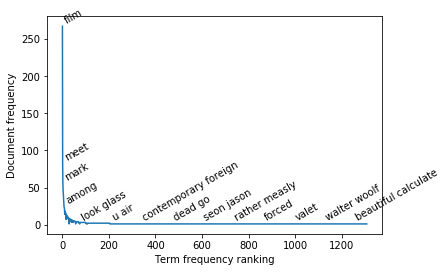

In [51]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

------------------T3 Q2--------------------- 

Based on the ZIPF plot:
From most left, top 10 least useful terms: 
(most-left)film, fall, another, animated, ferrer
(most-right)house eccentric, since husband, showbiz melodrama, mother boyfriend, top busily.
This is because terms from most left appear too frequently in most documents and most right terms are too specific, thus do not add value to clustering

In [7]:
print(df['Genre'].unique())

['Documentary' 'SciFi' 'Kids&Family' 'Romance']


# Find optimal number of clusters

In [54]:

# tf idf vectoriser WITH FILTER
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=0.02, max_df=0.7)
X = tfidf_vec.fit_transform(df['Description'])# + " " + df["Title"]) # derive genre from clusters

In [55]:
print(len(tfidf_vec.get_feature_names()))

641


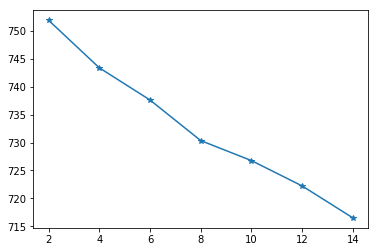

In [56]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X) # (X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

In [57]:
from sklearn.metrics import silhouette_score

sil_scores = []

for t in clusters:
    sil_scores.append(silhouette_score(X,t.predict(X)))

min_score = min(sil_scores)
max_score = max(sil_scores)

# index of lowest and highest score 
print(sil_scores.index(min_score))
print(sil_scores.index(max_score))

print(sil_scores)

0
6
[0.006266941046316203, 0.007585302137036921, 0.007333660502545074, 0.008794313773528115, 0.008375030762101878, 0.008738512396237201, 0.010106460400407219]


Cluster k = 8 with silhoutte score of 0.0008792029

In [58]:
kmeans = KMeans(n_clusters=8, random_state=rs).fit(X) #X is filtered
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: war, one, alien, world, u, 
Top terms for cluster 1: voice, adventure, world, find, save, 
Top terms for cluster 2: film, documentary, include, make, new, 
Top terms for cluster 3: life, love, change, find, one, 
Top terms for cluster 4: love, young, fall, woman, star, 
Top terms for cluster 5: christmas, holiday, visit, like, spirit, 
Top terms for cluster 6: year, old, year old, boy, family, 
Top terms for cluster 7: kid, one, hand, new, james, 


sci fi
kids and family
documentary
romance
romance
kids and family

T3 Q3: Disregard "film" because it occurs in too many documents, thus do not add value to clustering.

T3 Q4: 
td-idf, where more count = term has higher weight but also takes into account the number of occurences between each "descrption" to offset the fact that some words just occur more frequently in general

T3 Q5: 1 input feature - "Description" ???